# Import Dependencies

In [1]:
# Initial imports.
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sn
import matplotlib.pyplot as plt

# Initial Trial with csv files

In [2]:
# from google.colab import files 
# uploaded = files.upload()

In [3]:
# import io
# df = pd.read_csv(io.BytesIO(uploaded['ml_BattingFielding.csv']))
# df.head()
# # Dataset is now stored in a Pandas Dataframe

# Database Connection

In [4]:
# dependencies
import psycopg2
from config import config

In [5]:
# get parameters
params = config()

In [6]:
# connect to PostgreSQL database
conn = psycopg2.connect(**params)

# create a new cursor
cur = conn.cursor()

In [7]:
# funcion to create a pandas df given parameters of: 1. SQL query 2. database connection
def create_pandas_table(sql_query, database = conn):
    table = pd.read_sql_query(sql_query, database)
    return table

In [8]:
# trial with only 1 table
batting_df = create_pandas_table('SELECT * FROM "Batting"')
batting_df.head()

,playerID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP,AVG
0,aardsda01,331,4,0,0,0,0,0,0.0,0.0,0.0,0,2.0,0.0,0.0,1.0,0.0,0.0,0.000000
1,aaronha01,3298,12364,2174,3771,624,98,755,2297.0,240.0,73.0,1402,1383.0,293.0,32.0,21.0,121.0,328.0,0.304998
2,aaronto01,437,944,102,216,42,6,13,94.0,9.0,8.0,86,145.0,3.0,0.0,9.0,6.0,36.0,0.228814
3,aasedo01,448,5,0,0,0,0,0,0.0,0.0,0.0,0,3.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,abadan01,15,21,1,2,0,0,0,0.0,0.0,1.0,4,5.0,0.0,0.0,0.0,0.0,1.0,0.095238


### Build batting and fielding dataframe

In [9]:
# build batting/fielding df for machine learning analysis with SQL JOIN  multiple tables
combined_df = create_pandas_table('SELECT h."playerID",h."inducted", b."R",b."H",b."2B",b."3B",b."HR",b."RBI",b."SB", \
                                   b."CS",b."BB",b."SO",b."IBB",b."SH",b."SF",b."GIDP",b."AVG",f."PO",f."A",f."E", \
                                   f."DP",a."award_count" \
                                   FROM "Hall_Of_Fame" AS h \
                                   INNER JOIN "Batting" as b ON (h."playerID" = b."playerID") \
                                   INNER JOIN "Fielding" as f ON (h."playerID" = f."playerID") \
                                   INNER JOIN "Awards" as a ON (h."playerID" = a."playerID")')
combined_df.head()

,playerID,inducted,R,H,2B,3B,HR,RBI,SB,CS,...,IBB,SH,SF,GIDP,AVG,PO,A,E,DP,award_count
0,aaronha01,Y,2174,3771,624,98,755,2297.0,240.0,73.0,...,293.0,21.0,121.0,328.0,0.304998,7436,429,144.0,218,16
1,abbotji01,N,0,2,0,0,0,3.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.095238,72,300,9.0,16,2
2,adamsba01,N,79,216,31,15,3,75.0,1.0,1.0,...,0.0,35.0,0.0,0.0,0.211973,58,648,17.0,17,2
3,ageeto01,N,558,999,170,27,130,433.0,167.0,81.0,...,26.0,21.0,15.0,99.0,0.255368,2371,53,61.0,18,3
4,akerja01,N,3,7,2,0,0,4.0,0.0,0.0,...,0.0,10.0,0.0,1.0,0.076087,65,167,8.0,20,1


In [10]:
combined_df.shape

(751, 22)

In [11]:
combined_df.isnull().sum()

playerID       0
inducted       0
R              0
H              0
2B             0
3B             0
HR             0
RBI            0
SB             0
CS             0
BB             0
SO             0
IBB            0
SH             0
SF             0
GIDP           0
AVG            5
PO             0
A              0
E              0
DP             0
award_count    0
dtype: int64

In [12]:
# drop the rows with null values
combined_df = combined_df.dropna(subset=['AVG'])

In [13]:
# double check df shape
combined_df.shape

(746, 22)

### Build pitching dataframe

In [14]:
# build pitching df for machine learning analysis with SQL JOIN multiple tables
pitching_df = create_pandas_table('SELECT h."playerID",h."inducted",p."W",p."L",p."CG",p."SHO",p."SV", \
                                    p."H_allowed",p."ER",p."HR_allowed",p."BB_allowed",p."StruckOut",p."BAOpp", \
                                    p."ERA",p."WP",p."HitBatsmen",p."BK",p."R_allowed",p."SH_allowed",p."SF_allowed", \
                                    p."GIDP_pitcher",a."award_count" \
                                    FROM "Hall_Of_Fame" AS h \
                                    INNER JOIN "Pitching" as p ON (h."playerID" = p."playerID") \
                                    INNER JOIN "Awards" as a ON (h."playerID" = a."playerID")')
pitching_df.head()

,playerID,inducted,W,L,CG,SHO,SV,H_allowed,ER,HR_allowed,...,BAOpp,ERA,WP,HitBatsmen,BK,R_allowed,SH_allowed,SF_allowed,GIDP_pitcher,award_count
0,abbotji01,N,87,108,31,6,0,1779,791,154,...,0.280364,4.496364,53,32.0,11,880,70.0,47.0,200.0,2
1,adamsba01,N,194,140,206,44,15,2841,917,68,...,0.256667,3.733684,26,47.0,2,1129,0.0,0.0,0.0,2
2,akerja01,N,47,45,0,0,123,679,272,64,...,0.253571,3.854286,13,40.0,0,312,32.0,12.0,19.0,1
3,alexape01,Y,373,208,437,90,32,4868,1476,164,...,0.253810,2.972381,39,70.0,1,1851,0.0,0.0,0.0,21
4,allenjo02,N,142,75,109,17,18,1849,813,104,...,0.244667,3.765333,68,38.0,5,924,0.0,0.0,0.0,4


In [15]:
# check shape of df
pitching_df.shape

(284, 22)

In [16]:
# check for null values
pitching_df.isnull().sum()

playerID         0
inducted         0
W                0
L                0
CG               0
SHO              0
SV               0
H_allowed        0
ER               0
HR_allowed       0
BB_allowed       0
StruckOut        0
BAOpp           14
ERA              2
WP               0
HitBatsmen       0
BK               0
R_allowed        0
SH_allowed       0
SF_allowed       0
GIDP_pitcher     0
award_count      0
dtype: int64

In [17]:
# drop the rows with null values
pitching_df = pitching_df.dropna(subset=['ERA','BAOpp'])

In [18]:
# double check df shape
pitching_df.shape

(268, 22)

# Machine Learning

In [19]:
# define which dataframe will be used in machine learning model
# e.g. pitching or batting/fielding

# COMMENT OUT WHICHEVER YOU DO NOT WANT TO RUN!

df = combined_df

# df = pitching_df


In [20]:
# test conditional to compare / identify df's (for use later in code)
if df.equals(pitching_df):
    print('Pitching')
if df.equals(combined_df):
    print('Batting/Fielding')

Batting/Fielding


In [21]:
# encode inducted column from Y/N to numeric 0/1
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df2 = df.copy()
df2['inducted'] = le.fit_transform(df2['inducted'])

In [22]:
# encode playerID to numeric
# possibly remove if we want to keep playerID's as index to later reference player names

# df2['playerID'] = le.fit_transform(df2['playerID'])

In [23]:
# define input (X) and output (y) variables
# drop columns of unnecessary features in X 
# batting/fielding 1st iteration showed the following features contributed <3%:
# SF, CS, IBB, SB

y = df2["inducted"]
if df.equals(combined_df):
    X = df2.drop(columns=["inducted", "playerID", "SF", "CS", "IBB", "SB"])  # Batters/Fielders
if df.equals(pitching_df):
    X = df2.drop(columns=["inducted", "playerID"]) # Pitchers

In [24]:
# Splitting into Train and Test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [25]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78) 

In [27]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [28]:
# Making predictions using the testing data.
predictions = rf_model.predict(X_test_scaled)

In [29]:
# Calculating the confusion matrix.
cm = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

cm_df

,Predicted 0,Predicted 1
Actual 0,127,12
Actual 1,13,35


In [30]:
# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)

In [31]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,127,12
Actual 1,13,35


Accuracy Score : 0.8663101604278075
Classification Report
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       139
           1       0.74      0.73      0.74        48

    accuracy                           0.87       187
   macro avg       0.83      0.82      0.82       187
weighted avg       0.87      0.87      0.87       187



## Feature Importance

In [32]:
# Calculate feature importance in the Random Forest model & sort largest to smallest
importances = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances

[(0.16147912339241308, 'award_count'),
 (0.09405157260170642, 'R'),
 (0.09112768741100967, 'AVG'),
 (0.09031537296116243, 'H'),
 (0.06312932357843094, 'A'),
 (0.05852511210356192, 'RBI'),
 (0.055836295695513474, 'SO'),
 (0.048173059370415085, 'E'),
 (0.04618862487663315, 'PO'),
 (0.04595590841272363, '3B'),
 (0.0439440495451252, '2B'),
 (0.043821710445384736, 'SH'),
 (0.04295532881342847, 'BB'),
 (0.03826045232174703, 'GIDP'),
 (0.03818608929511483, 'DP'),
 (0.03805028917562995, 'HR')]

In [33]:
# sort the features by their importance.
sorted(zip(X.columns), reverse=True)

[('award_count',),
 ('SO',),
 ('SH',),
 ('RBI',),
 ('R',),
 ('PO',),
 ('HR',),
 ('H',),
 ('GIDP',),
 ('E',),
 ('DP',),
 ('BB',),
 ('AVG',),
 ('A',),
 ('3B',),
 ('2B',)]

In [34]:
rf_model.feature_importances_.sum()

1.0

In [35]:
x = [lis[-1] for lis in importances]
x

['award_count',
 'R',
 'AVG',
 'H',
 'A',
 'RBI',
 'SO',
 'E',
 'PO',
 '3B',
 '2B',
 'SH',
 'BB',
 'GIDP',
 'DP',
 'HR']

In [36]:
y = [lis[0] for lis in importances]
y

[0.16147912339241308,
 0.09405157260170642,
 0.09112768741100967,
 0.09031537296116243,
 0.06312932357843094,
 0.05852511210356192,
 0.055836295695513474,
 0.048173059370415085,
 0.04618862487663315,
 0.04595590841272363,
 0.0439440495451252,
 0.043821710445384736,
 0.04295532881342847,
 0.03826045232174703,
 0.03818608929511483,
 0.03805028917562995]

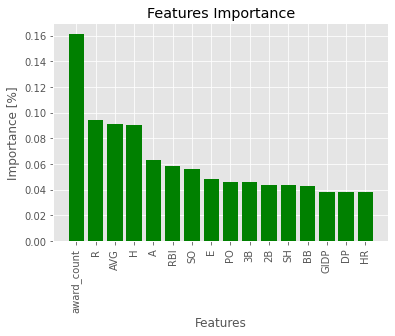

In [37]:

# DANE'S CODE:
# %matplotlib inline
# plt.style.use('ggplot')
# x = ['R', 'H', '2B', '3B', 'HR', 'RBI', 'BB', 'SO', 'SH', 'AVG', 'PO', 'A', 'E', 'DP', 'award_count']
# y = importances
# x_pos = [i for i, _ in enumerate(x)]

# plt.bar(x_pos, importances, color='green')
# plt.xlabel('Features Importance')
# plt.show()

# NICK's comments
# would like to investigate how to auto generate x list instead of manually entering
# Need to label x ticks
# would like to reorder, largest to smallest

# TRY THIS CODE:
%matplotlib inline
plt.style.use('ggplot')
x = [lis[-1] for lis in importances]
y = [lis[0] for lis in importances]
x_pos = [i for i, _ in enumerate(x)]

plt.bar(x_pos, y, color='green')
plt.title('Features Importance')
plt.xlabel('Features')
plt.ylabel('Importance [%]')

plt.xticks(x_pos,x,rotation=90,ha='center')
plt.savefig("analysis/Features.png")
plt.show()

## Investigate Predictions

In [38]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [39]:
print (X_test) #test dataset (without the actual outcome)
print (y_pred) #predicted values

        R     H   2B  3B   HR     RBI    BB     SO     SH   GIDP       AVG  \
549    82   187   35   4    4    79.0    46  317.0  135.0   11.0  0.167713   
543    45   112   15   1    1    50.0    47  145.0   63.0   17.0  0.184211   
537     0     1    0   0    0     1.0     1    1.0    0.0    0.0  0.166667   
563  1232  2848  482  68  268  1357.0   860  990.0  101.0  297.0  0.267317   
308    42    92   18   0    4    49.0    44  243.0  117.0    6.0  0.122995   
..    ...   ...  ...  ..  ...     ...   ...    ...    ...    ...       ...   
4       3     7    2   0    0     4.0     1   51.0   10.0    1.0  0.076087   
457   940  2091  484  66  191  1097.0   648  779.0   28.0  186.0  0.289692   
620  1074  2472  483  47  248  1389.0   855  694.0   11.0  287.0  0.284793   
627  1257  2460  402  69   28   793.0  1072  589.0  214.0  167.0  0.261814   
431    32    57    3   0    0    23.0    57  217.0   41.0    7.0  0.129252   

        PO     A      E    DP  award_count  
549    328   667  

In [40]:
df2

,playerID,inducted,R,H,2B,3B,HR,RBI,SB,CS,...,IBB,SH,SF,GIDP,AVG,PO,A,E,DP,award_count
0,aaronha01,1,2174,3771,624,98,755,2297.0,240.0,73.0,...,293.0,21.0,121.0,328.0,0.304998,7436,429,144.0,218,16
1,abbotji01,0,0,2,0,0,0,3.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.095238,72,300,9.0,16,2
2,adamsba01,0,79,216,31,15,3,75.0,1.0,1.0,...,0.0,35.0,0.0,0.0,0.211973,58,648,17.0,17,2
3,ageeto01,0,558,999,170,27,130,433.0,167.0,81.0,...,26.0,21.0,15.0,99.0,0.255368,2371,53,61.0,18,3
4,akerja01,0,3,7,2,0,0,4.0,0.0,0.0,...,0.0,10.0,0.0,1.0,0.076087,65,167,8.0,20,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,yountro01,1,1632,3142,583,126,251,1406.0,271.0,105.0,...,95.0,104.0,123.0,217.0,0.285429,5855,4850,305.0,963,12
747,zachrpa01,0,9,36,0,0,0,6.0,0.0,0.0,...,0.0,33.0,2.0,11.0,0.113208,60,176,13.0,19,1
748,zahnge01,0,3,6,0,0,0,1.0,0.0,0.0,...,0.0,10.0,0.0,1.0,0.139535,87,326,24.0,19,1
749,zambrca01,0,75,165,26,3,24,71.0,1.0,0.0,...,0.0,37.0,4.0,14.0,0.238095,168,290,25.0,29,3


In [41]:
df2.columns

Index(['playerID', 'inducted', 'R', 'H', '2B', '3B', 'HR', 'RBI', 'SB', 'CS',
       'BB', 'SO', 'IBB', 'SH', 'SF', 'GIDP', 'AVG', 'PO', 'A', 'E', 'DP',
       'award_count'],
      dtype='object')

In [42]:
# create df with all data to investigate statistical trends
df3 = pd.merge(X_test, df2[["inducted","playerID"]], how="inner", left_index=True, right_index=True)

if df.equals(combined_df):
    # This one is specific to Batting/Fielding!!!
    df3 = df3[['playerID','R','H','2B','3B','HR','RBI','BB','SO','SH','GIDP','AVG','PO','A','E','DP','award_count','inducted']]
    
if df.equals(pitching_df):
    # This one is specific to Pitching
    df3 = df3[['playerID','W','L','CG','SHO','SV','H_allowed','ER','HR_allowed','BB_allowed','StruckOut','BAOpp','ERA','WP','HitBatsmen','BK','R_allowed','SH_allowed','SF_allowed','GIDP_pitcher','award_count','inducted']]
    
df3["predicted"] = y_pred   
df3

,playerID,R,H,2B,3B,HR,RBI,BB,SO,SH,GIDP,AVG,PO,A,E,DP,award_count,inducted,predicted
549,reuscri01,82,187,35,4,4,79.0,46,317.0,135.0,11.0,0.167713,328,667,29.0,39,4,0,1
543,raschvi01,45,112,15,1,1,50.0,47,145.0,63.0,17.0,0.184211,84,259,8.0,20,6,0,0
537,quiseda01,0,1,0,0,0,1.0,1,1.0,0.0,0.0,0.166667,97,264,13.0,22,10,0,1
563,robinbr01,1232,2848,482,68,268,1357.0,860,990.0,101.0,297.0,0.267317,2712,6220,264.0,621,32,1,1
308,hootobu01,42,92,18,0,4,49.0,44,243.0,117.0,6.0,0.122995,165,373,16.0,21,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,akerja01,3,7,2,0,0,4.0,1,51.0,10.0,1.0,0.076087,65,167,8.0,20,1,0,0
457,mcraeha01,940,2091,484,66,191,1097.0,648,779.0,28.0,186.0,0.289692,887,84,41.0,18,4,0,0
620,simmote01,1074,2472,483,47,248,1389.0,855,694.0,11.0,287.0,0.284793,10544,1092,169.0,248,4,0,0
627,smithoz01,1257,2460,402,69,28,793.0,1072,589.0,214.0,167.0,0.261814,4249,8375,281.0,1590,23,1,1


In [43]:
#perform a prediction
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
batting_prediction = [600,1500,500,100, 200, 1300, 400, 500, 100, 40, 0.3, 4000, 140, 80, 30, 20]
pitching_prediction = [303,166,100,37,2,3346,1513,411,1497,4875,0.225166667,3.480833333,109,190,33,1703,131,89,251,13]

# Batting/Fielding Prediction (COMMENT OUT IF USING PITCHING)
if df.equals(combined_df):
    prediction = clf.predict([batting_prediction])
if df.equals(pitching_df):
    prediction = clf.predict([pitching_prediction])

print ('Predicted Result: ', prediction)

Predicted Result:  [1]


# Build Interactive User Input

In [44]:
import tkinter as tk

## Batting / Fielding Input

In [ ]:
if df.equals(combined_df):
    # tkinter GUI
    root= tk.Tk()
    root.title("Batting/Fielding")

    canvas1 = tk.Canvas(root, width = 500, height = 1400)
    canvas1.pack()

    # R input
    label1 = tk.Label(root, text='R:')
    canvas1.create_window(200, 100, window=label1)

    entry1 = tk.Entry (root)
    canvas1.create_window(270, 100, window=entry1)

    # H input
    label2 = tk.Label(root, text='H:')
    canvas1.create_window(200, 120, window=label2)

    entry2 = tk.Entry (root)
    canvas1.create_window(270, 120, window=entry2)

    # 2B input
    label3 = tk.Label(root, text='2B: ')
    canvas1.create_window(200, 140, window=label3)

    entry3 = tk.Entry (root)
    canvas1.create_window(270, 140, window=entry3)

    # 3B input
    label4 = tk.Label(root, text='3B:  ')
    canvas1.create_window(200, 160, window=label4)

    entry4 = tk.Entry (root)
    canvas1.create_window(270, 160, window=entry4)

    # HR input
    label5 = tk.Label(root, text='HR:  ')
    canvas1.create_window(200, 180, window=label5)

    entry5 = tk.Entry (root)
    canvas1.create_window(270, 180, window=entry5)

    # RBI input
    label6 = tk.Label(root, text='RBI:  ')
    canvas1.create_window(200, 200, window=label6)

    entry6 = tk.Entry (root)
    canvas1.create_window(270, 200, window=entry6)

    # BB input
    label7 = tk.Label(root, text='BB:  ')
    canvas1.create_window(200, 220, window=label7)

    entry7 = tk.Entry (root)
    canvas1.create_window(270, 220, window=entry7)

    # SO input
    label8 = tk.Label(root, text='SO:  ')
    canvas1.create_window(200, 240, window=label8)

    entry8 = tk.Entry (root)
    canvas1.create_window(270, 240, window=entry8)

    # SH input
    label9 = tk.Label(root, text='SH:  ')
    canvas1.create_window(200, 260, window=label9)

    entry9 = tk.Entry (root)
    canvas1.create_window(270, 260, window=entry9)

    # GIDP input
    label10 = tk.Label(root, text='GIDP:     ')
    canvas1.create_window(200, 280, window=label10)

    entry10 = tk.Entry (root)
    canvas1.create_window(270, 280, window=entry10)

    # AVG input
    label11 = tk.Label(root, text='AVG:    ')
    canvas1.create_window(200, 300, window=label11)

    entry11 = tk.Entry (root)
    canvas1.create_window(270, 300, window=entry11)

    # PO input
    label12 = tk.Label(root, text='PO:  ')
    canvas1.create_window(200, 320, window=label12)

    entry12 = tk.Entry (root)
    canvas1.create_window(270, 320, window=entry12)

    # A input
    label13 = tk.Label(root, text='A:  ')
    canvas1.create_window(200, 340, window=label13)

    entry13 = tk.Entry (root)
    canvas1.create_window(270, 340, window=entry13)

    # E input
    label14 = tk.Label(root, text='E:  ')
    canvas1.create_window(200, 360, window=label14)

    entry14 = tk.Entry (root)
    canvas1.create_window(270, 360, window=entry14)

    # DP input
    label15 = tk.Label(root, text='DP:  ')
    canvas1.create_window(200, 380, window=label15)

    entry15 = tk.Entry (root)
    canvas1.create_window(270, 380, window=entry15)

    # award_count input
    label16 = tk.Label(root, text='award_count:         ')
    canvas1.create_window(180, 400, window=label16)

    entry16 = tk.Entry (root)
    canvas1.create_window(270, 400, window=entry16)

    # # inducted input
    # label17 = tk.Label(root, text='inducted:  ')
    # canvas1.create_window(420, 420, window=label17)

    # entry17 = tk.Entry (root)
    # canvas1.create_window(270, 420, window=entry17)


    def values(): 
        global R
        R = float(entry1.get()) 

        global H
        H = float(entry2.get()) 

        global Double
        Double = float(entry3.get()) 

        global Triple
        Triple = float(entry4.get())

        global HR
        HR = float(entry5.get())

        global RBI
        RBI = float(entry6.get())

        global BB
        BB = float(entry7.get())

        global SO
        SO = float(entry8.get()) 

        global SH
        SH = float(entry9.get())

        global GIDP
        GIDP = float(entry10.get())

        global AVG
        AVG = float(entry11.get()) 

        global PO
        PO = float(entry12.get())

        global A
        A = float(entry13.get())

        global E
        E = float(entry14.get())

        global DP
        DP = float(entry15.get()) 

        global award_count
        award_count = float(entry16.get())

    #     global inducted
    #     inducted = float(entry17.get())           

        Prediction_result  = ('  Predicted Result: ', clf.predict([[R, H, Double, Triple, HR, RBI, BB, SO, SH, GIDP, AVG, PO, A, E, DP, award_count ]]))
        label_Prediction = tk.Label(root, text= Prediction_result, bg='sky blue')
        canvas1.create_window(270, 480, window=label_Prediction)

    button1 = tk.Button (root, text='      Predict      ',command=values, bg='green', fg='white', font=11)
    canvas1.create_window(270, 440, window=button1)

    root.mainloop()


## Pitching Input

In [ ]:
if df.equals(pitching_df):
    # tkinter GUI
    root= tk.Tk()
    root.title("Pitching")

    canvas1 = tk.Canvas(root, width = 500, height = 2000)
    canvas1.pack()

    # W input
    label1 = tk.Label(root, text='W:')
    canvas1.create_window(200, 100, window=label1)

    entry1 = tk.Entry (root)
    canvas1.create_window(270, 100, window=entry1)

    # L input
    label2 = tk.Label(root, text='L:')
    canvas1.create_window(200, 120, window=label2)

    entry2 = tk.Entry (root)
    canvas1.create_window(270, 120, window=entry2)

    # CG input
    label3 = tk.Label(root, text='CG: ')
    canvas1.create_window(200, 140, window=label3)

    entry3 = tk.Entry (root)
    canvas1.create_window(270, 140, window=entry3)

    # SHO input\n",
    label4 = tk.Label(root, text='SHO:  ')
    canvas1.create_window(200, 160, window=label4)

    entry4 = tk.Entry (root)
    canvas1.create_window(270, 160, window=entry4)

    # SV input
    label5 = tk.Label(root, text='SV:  ')
    canvas1.create_window(200, 180, window=label5)

    entry5 = tk.Entry (root)
    canvas1.create_window(270, 180, window=entry5)

    # H_allowed input
    label6 = tk.Label(root, text='H_allowed:  ')
    canvas1.create_window(200, 200, window=label6)

    entry6 = tk.Entry (root)
    canvas1.create_window(270, 200, window=entry6)

    # ER input
    label7 = tk.Label(root, text='ER:  ')
    canvas1.create_window(200, 220, window=label7)

    entry7 = tk.Entry (root)
    canvas1.create_window(270, 220, window=entry7)

    # HR_allowed input
    label8 = tk.Label(root, text='HR_allowed:  ')
    canvas1.create_window(200, 240, window=label8)

    entry8 = tk.Entry (root)
    canvas1.create_window(270, 240, window=entry8)

    # BB_allowed input
    label9 = tk.Label(root, text='BB_allowed:  ')
    canvas1.create_window(200, 260, window=label9)

    entry9 = tk.Entry (root)
    canvas1.create_window(270, 260, window=entry9)

    # Struckout input
    label10 = tk.Label(root, text='Struckout:     ')
    canvas1.create_window(200, 280, window=label10)

    entry10 = tk.Entry (root)
    canvas1.create_window(270, 280, window=entry10)

    # BAOpp input
    label11 = tk.Label(root, text='BAOpp:    ')
    canvas1.create_window(200, 300, window=label11)

    entry11 = tk.Entry (root)
    canvas1.create_window(270, 300, window=entry11)

    # ERA input
    label12 = tk.Label(root, text='ERA:  ')
    canvas1.create_window(200, 320, window=label12)

    entry12 = tk.Entry (root)
    canvas1.create_window(270, 320, window=entry12)

    # WP input
    label13 = tk.Label(root, text='WP:  ')
    canvas1.create_window(200, 340, window=label13)

    entry13 = tk.Entry (root)
    canvas1.create_window(270, 340, window=entry13)

    # HitBatsmen input
    label14 = tk.Label(root, text='HitBatsmen:  ')
    canvas1.create_window(200, 360, window=label14)

    entry14 = tk.Entry (root)
    canvas1.create_window(270, 360, window=entry14)

    # BK input
    label15 = tk.Label(root, text='BK:  ')
    canvas1.create_window(200, 380, window=label15)

    entry15 = tk.Entry (root)
    canvas1.create_window(270, 380, window=entry15)

    # R_allowed input
    label16 = tk.Label(root, text='R_allowed:         ')
    canvas1.create_window(180, 400, window=label16)

    entry16 = tk.Entry (root)
    canvas1.create_window(270, 400, window=entry16)

    # SH_allowed input
    label17 = tk.Label(root, text='SH_allowed:         ')
    canvas1.create_window(180, 420, window=label17)

    entry17 = tk.Entry (root)
    canvas1.create_window(270, 420, window=entry17)

    # SF_allowed input
    label18 = tk.Label(root, text='SF_allowed:         ')
    canvas1.create_window(180, 440, window=label18)

    entry18 = tk.Entry (root)
    canvas1.create_window(270, 440, window=entry18)

    # GIDP_pitcher input
    label19 = tk.Label(root, text='GIDP_pitcher:         ')
    canvas1.create_window(180, 460, window=label19)

    entry19 = tk.Entry (root)
    canvas1.create_window(270, 460, window=entry19)

    # award_count input
    label20 = tk.Label(root, text='award_count:         ')
    canvas1.create_window(180, 480, window=label20)

    entry20 = tk.Entry (root)
    canvas1.create_window(270, 480, window=entry20)

    # inducted input
    # label17 = tk.Label(root, text='inducted:  ')
    # canvas1.create_window(420, 420, window=label17)

    # entry17 = tk.Entry (root)
    # canvas1.create_window(270, 420, window=entry17)


    def values(): 
        global W
        W = float(entry1.get())

        global L
        L = float(entry2.get())

        global CG
        CG = float(entry3.get())

        global SHO
        SHO = float(entry4.get())

        global SV
        SV = float(entry5.get())

        global H_allowed
        H_allowed = float(entry6.get())

        global ER
        ER = float(entry7.get())

        global HR_allowed
        HR_allowed = float(entry8.get())

        global BB_allowed
        BB_allowed = float(entry9.get()) 

        global Struckout
        Struckout = float(entry10.get())

        global BAOpp
        BAOpp = float(entry11.get())

        global ERA
        ERA = float(entry12.get()) 

        global WP
        WP = float(entry13.get())

        global HitBatsmen
        HitBatsmen = float(entry14.get())

        global BK
        BK = float(entry15.get())

        global R_allowed
        R_allowed = float(entry16.get()) 

        global SH_allowed
        SH_allowed = float(entry17.get())

        global SF_allowed
        SF_allowed = float(entry18.get())

        global GIDP_pitcher
        GIDP_pitcher = float(entry19.get())

        global award_count
        award_count = float(entry20.get())

    #     global inducted\n",
    #     inducted = float(entry17.get())           \n",

        Prediction_result  = ('  Predicted Result: ', clf.predict([[W, L, CG, SHO, SV, H_allowed, ER, HR_allowed, \
                                BB_allowed, Struckout, BAOpp, ERA, WP, HitBatsmen, BK, R_allowed, SH_allowed, SF_allowed, \
                                                                    GIDP_pitcher, award_count ]]))
        label_Prediction = tk.Label(root, text= Prediction_result, bg='sky blue')
        canvas1.create_window(270, 520, window=label_Prediction)

    button1 = tk.Button (root, text='      Predict      ',command=values, bg='green', fg='white', font=11)
    canvas1.create_window(270, 500, window=button1)

    root.mainloop()

In [ ]:
mean_summary_pred = df3.groupby('predicted').mean()
mean_summary_pred

In [ ]:
if df.equals(combined_df):
    mean_summary_pred.to_csv("Scorecard_Batters.csv")
if df.equals(pitching_df):
    mean_summary_pred.to_csv("Scorecard_Pitchers.csv")


In [ ]:

labels = mean_summary_pred.columns.tolist()

pred_no = mean_summary_pred.iloc[0].tolist()
pred_yes = mean_summary_pred.iloc[1].tolist()


x = np.arange(len(labels))
w = 0.25

plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(20,10))
rects1 = ax.bar(x-w/2,pred_no,w,label='Not Inducted', color='b')
rects2 = ax.bar(x+w/2,pred_yes,w,label='Inducted', color='orange')

ax.set_title('Predicted Features of Baseball Hall Of Fame Machine Learning Model', fontsize=24)
ax.set_xlabel('Features')
ax.set_ylabel('')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(title='Inducted to HOF?')


# auto label function
# (found at https://matplotlib.org/3.3.0/gallery/lines_bars_and_markers/barchart.html#sphx-glr-gallery-lines-bars-and-markers-barchart-py)

def autolabel(rects):
    # """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.1f}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# call function to apply data labels 
autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# Save Figure
# plt.savefig("analysis/TempsChart.png")

plt.show()